# Does layer predict cell misses?

author: steeve.laquitaine@epfl.ch

Setup environment: 

```bash
pip install requirements_kilosort_silico
```

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

# from src.pipes.sorting import match_sorted_to_true_neuropixels_2023_02_19 as match
from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import match_firing_rate, match_property
from src.nodes.postpro import feateng

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"


# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'match_firing_rate' from 'src.nodes.postpro.cell_matching' (/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py)

In [2]:
# get SpikeInterface's MatchingObject
out = match.run()

2023-03-16 11:30:30,071 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-03-16 11:30:30,159 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.1
2023-03-16 11:30:30,161 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-03-16 11:30:30,216 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.1
2023-03-16 11:30:46,494 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-03-16 11:30:46,502 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [9]:
cell_matching  = out["cell_matching"]

# add layer feature
cell_matching = feateng.add_property(
    cell_matching, data_conf, properties=["layer"]
)

In [10]:
cell_matching

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,sorted_cell,true_cell_match,oversplit_true_cell,agreement_score,layer
0,0.0,1981516,True,0.430918,6
1,215.0,1981516,True,0.000717,6
2,1.0,3427256,True,0.000000,5
3,45.0,3427256,True,0.000000,5
4,2.0,2145865,False,0.000880,6
...,...,...,...,...,...
640,NaN,4046827,NaN,NaN,5
641,NaN,4138989,NaN,NaN,5
642,NaN,4063216,NaN,NaN,5
643,NaN,2623483,NaN,NaN,4


In [150]:
missed_cells = cell_matching["sorted_cell"].isna()
n_missed_per_layer = cell_matching[missed_cells].drop_duplicates().groupby("layer").size()
n_total_per_layer = cell_matching[["true_cell_match", "layer"]].drop_duplicates().groupby("layer").size()

detected
missed


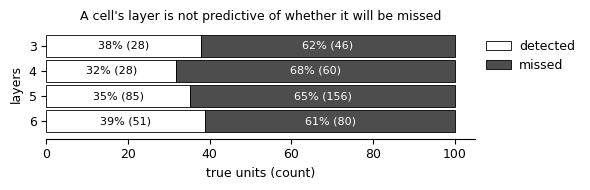

In [147]:
from matplotlib import pyplot as plt

# build histo dataset
df = pd.DataFrame(
    {
        "detected": n_total_per_layer - n_missed_per_layer,
        "missed": n_missed_per_layer,
    },
    index=list(n_missed_per_layer.index),
)
df_total = df["missed"] + df["detected"]
df_rel = df.div(df_total, 0) * 100

# set figure
fig, axis = plt.subplots(1, 1, figsize=(6, 2))


# set plot legend
colors = ["w", [0.3, 0.3, 0.3],]

# plot
ax = df_rel.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.9,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
ax.invert_yaxis()
ax.set_xlabel("true units (count)", fontsize=9)
ax.set_ylabel("layers", fontsize=9)
ax.legend(
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("A cell's layer is not predictive of whether it will be missed", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

  
for n in df_rel:
    print(n)
    for i, (cs, ab, pc) in enumerate(zip(df_rel.cumsum(1)[n], 
                                         df_rel[n], df_rel[n])):
        if n=="missed":
            txt_color="w"
        else:
            txt_color="k"
        plt.text(cs - ab / 2, i, "{:.0f}% ({:.0f})".format(np.round(pc), df[n].iloc[i]), 
                va = 'center', ha = 'center', fontsize = 8, color=txt_color)